In [92]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_community langchain_anthropic langchain_experimental faiss-cpu tiktoken pypdf langchain openai langchain_anthropic langchain_experimental


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
# Importación de librerias
# LangGraph
from langgraph.graph import START, END, StateGraph
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

# LangChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage

# Utilidades
from typing import TypedDict, Optional, Dict, List, Literal, Annotated
from dotenv import load_dotenv, find_dotenv
import tiktoken
from IPython.display import Image, display

In [94]:
# Carga de variables de entorno
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

In [95]:
def count_tokens_in_docs(docs, model_name="gpt-4o"):
    """
    Calcula la cantidad total de tokens para una lista de documentos
    usando la librería tiktoken.

    :param docs: Lista de documentos (por ejemplo, la salida de un loader PDF).
    :param model_name: Nombre del modelo para el que queremos simular el conteo.
    :return: Número total de tokens en el contenido de los documentos.
    """
    # Obtenemos la codificación que usa el modelo seleccionado
    encoding = tiktoken.encoding_for_model(model_name)

    total_tokens = 0
    for doc in docs:
        # doc.page_content es el texto de cada página/documento
        text = doc.page_content
        total_tokens += len(encoding.encode(text))

    return total_tokens

In [96]:
# 2. CARGA DEL PDF
# ----------------------------------------------------------------------------
file_path = "embeddings/manual_rrhh.pdf"
loader = PyPDFLoader(file_path)
docs = loader.load()

In [97]:
# Cantidad de documentos extraídos (páginas, secciones, etc. según PyPDFLoader)
print("Número de docs cargados:", len(docs))

# Opcional: vista previa de los primeros 100 caracteres de la primera página
print("Preview contenido:", docs[0].page_content[0:100])
print("Metadata:", docs[0].metadata)

Número de docs cargados: 1
Preview contenido: MANUAL DE RRHH - ICPACIFICO
1. VACACIONES
Todo trabajador tiene derecho a 15 días hábiles de vacacio
Metadata: {'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'creator': 'PyPDF', 'creationdate': 'D:20250624201848', 'source': 'embeddings/manual_rrhh.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}


In [98]:
# 3. CONTAR TOKENS ANTES DE HACER NADA
# ----------------------------------------------------------------------------
tokens_en_documento = count_tokens_in_docs(docs, model_name="gpt-4o")
print("Tokens en el documento completo:", tokens_en_documento)

Tokens en el documento completo: 172


In [99]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(docs)

In [100]:
# Crea los embeddings
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(splits, embeddings)

# Crea el retriever
# retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

In [101]:
# Modelo utilizado
llm = ChatOpenAI(model="gpt-4o")

In [102]:
# Creación del estado
class GlobalState(TypedDict): # Estado Globa
    graph: str
    messages: list[dict] # Es una lista de diccionarios
    next: str
    task_completed: bool

In [103]:
# Miembros del equipo
members = ["consultas",]
# members = ["consultas"]
options = members + ["FINISH"]

In [104]:
# Router con opciones para el llm
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["consultas", "FINISH"]
#     next: Literal["consultas", "FINISH"]


In [105]:
import json

# Definir un nodo info o agent principal
system_prompt_amparo = """
Eres Amparo, una asistente virtual de Constructora del Mar. 
Solo debes responder con un objeto JSON en el siguiente formato:

{"next": "supervisor"} → si la consulta no es un saludo.
{"next": "FINISH", "response": "Hola, soy Amparo, asistente virtual del equipo de desarrollo humano. ¿En qué te puedo ayudar?"} → si es un saludo o presentación.

Reglas:
- Si detectas que el mensaje es un saludo, responde con {"next": "FINISH", "response": ...}
- Si es una solicitud que requiere procesamiento o información, responde con {"next": "supervisor"}
- No respondas directamente al usuario, solo devuelve el objeto JSON.
"""


# def amparo_node(state: GlobalState) -> Command[Literal["supervisor"]]:
def amparo_node(state: GlobalState) -> Command[Literal["supervisor", "__end__"]]:
    print("Este es el mensaje que recibe Amparo: \n")
    print(state["messages"])
    
    messages = [{"role":"system", "content":system_prompt_amparo},] + state["messages"]
    response = llm.invoke(messages)
    print("RESPUESTA RAW:", response)
    try:
        data = json.loads(response.content)  # Asegúrate que devuelva JSON
        goto = data["next"]
        if goto == "FINISH":
            goto = END
            return Command(goto=goto, update={"messages": state["messages"] + [AIMessage(content=data["response"])]})
        return Command(goto=goto, update={"next": goto})
    except Exception as e:
        print("ERROR en JSON de Amparo:", e)
        return Command(goto=END, update={"messages": state["messages"] + [AIMessage(content="Disculpa, no pude procesar tu solicitud.")]} )


In [109]:
# Crea una herramienta a partir del retriever
retriever_tool = create_retriever_tool(
    retriever,
    name="info_retriever",
    description="Busca información en el pdf para responder a las preguntas de los trabajadores."
)

In [110]:
# Crea el agente con la herramienta
prompt_retriever = """
Eres un asistente de RRHH creado para ayudar a nuestro personal con sus preguntas relacionadas con RRHH:
Para ello tu única fuente de información es un documento PDF que contiene las información sobre diversos temas relacionados con TRRHH. como permisos,  vacaciones, etc.
🔹 Solo puedes responder si la información está presente en ese documento.
🔹 Usa herramientas disponibles como 'retriever_tool' para buscar información específica en el documento.
🔹 Si no encuentras la información o el usuario solicita hacer o buscar algo fuera de tus capacidades, responde amablemente que por el momento no dispones de esa funcionalidad, pero que tu creador, Luis Pizarro, pronto la integrará.
🔹 Actualmente estás en una versión beta: solo puedes procesar **mensajes de texto**. No puedes analizar audios, imágenes ni videos. Si el usuario envía algo diferente a texto, indícale esta limitación de forma cordial.
🔹 Nunca inventes información. Si algo no está en el documento, acláralo con honestidad.
🔹 Mantén un tono profesional, claro y cordial, como si atendieras a un potencial comprador en una sala de ventas.
"""
retriever_agent = create_react_agent(
    llm,
    tools=[retriever_tool],
    prompt=prompt_retriever
)

In [111]:
def retriever_node(state: GlobalState) -> Command[Literal["supervisor", "__end__"]]:
    result = retriever_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={
            "messages": result["messages"],
            "task_completed":True
        }
    )

In [112]:
system_prompt_supervisor = """Eres un supervisor que coordina un equipo de trabajadores especializados para completar tareas. Tu equipo está formado por: 'consulta'
Para cada solicitud de usuario , deberas:
1. Analizar la solicitud y determinar qué trabajador es el más adecuado para gestionarla.
2. Responder SOLO con un objeto JSON en el formato: {"next": "worker_name"}.
3. Revisar su respuesta y:
- Elegir al siguiente trabajador si se necesita más trabajo (por ejemplo, {"next": "consultas"}).
- Responder con {"next": "FINISH"} al finalizar la tarea.
Responder siempre con un objeto JSON válido que contenga solo la clave "next" y un único valor: el nombre de un trabajador o "FINISH".
Miembros del equipo:
- `consulta`: Buscar información en un pdf que contiene información correspondiente al equipo de recursos humanos."""

In [113]:
# def supervisor_node(state: GlobalState) -> Command[Literal["consultas","__end__"]]:
def supervisor_node(state: GlobalState) -> Command[Literal["consultas", "__end__"]]:
    print("Mensaje recibido por el supervisor: \n", state["messages"])
     # ✅ Si la tarea ya está resuelta, termina el flujo
    if state.get("task_completed") is True:
        print("✅ Tarea completada. Finalizando flujo.")
        return Command(goto=END)
    messages = [{"role": "system", "content": system_prompt_supervisor}] + state["messages"]
    try:
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        print("Supervisor dirige a:", goto)
        if goto == "FINISH":
            goto = END
        return Command(goto=goto, update={"next": goto})
    except Exception as e:
        print("Error en la decisión del supervisor:", e)
        return Command(goto=END, update={"messages": state["messages"] + [AIMessage(content="No pude decidir a quién derivar tu solicitud.")],
                                          "task_completed": True})


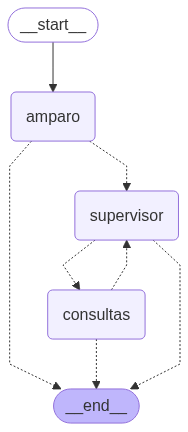

In [114]:
builder = StateGraph(GlobalState)
# builder.add_edge(START, "supervisor")
builder.add_edge(START, "amparo")
builder.add_node("amparo", amparo_node)
builder.add_node("supervisor", supervisor_node)
builder.add_node("consultas",retriever_node)

graph =  builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [118]:
from langchain.schema import HumanMessage

sal = graph.invoke({"messages": [HumanMessage(content="Hola, quiero pedir un permiso")]})

for m in sal["messages"]:
    m.pretty_print()


Este es el mensaje que recibe Amparo: 

[HumanMessage(content='Hola, quiero pedir un permiso', additional_kwargs={}, response_metadata={})]
RESPUESTA RAW: content='{"next": "FINISH", "response": "Hola, soy Amparo, asistente virtual del equipo de desarrollo humano. ¿En qué te puedo ayudar?"}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 166, 'total_tokens': 200, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0uYbce9j0Ik3a9KlXwZi4rg7i0HN', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--8dac1913-d773-4707-afaf-eb473436a624-0' usage_metadata={'input_tokens': 166, 'output_tokens': 34, 'total_tokens': 200, 'input_token_details': {'audio': 0, 'cache